In [2]:
import geopandas as gpd
from shapely.geometry import LineString
import rasterio
import numpy as np
from rasterio.sample import sample_gen
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.sample import sample_gen
from pathlib import Path
from src.myio import read_csv, write_parquet, read_dem, read_parquet


In [3]:
# df = read_csv("table/data.csv")
# dem = read_dem("output/dem_fabdem.tif", mode="xdem")
df_ortometric = read_parquet("output/icesat2_region_orthometric.parquet")



In [8]:
print(df_ortometric.head())


   region  gt  spacecraft_velocity  solar_elevation  longitude  rgt  ph_index  \
0       6  10          7108.730469       -49.910126  24.901195  998     22408   
1       6  10          7108.730469       -49.910126  24.901148  998     22419   
2       6  10          7108.730469       -49.910126  24.901139  998     22422   
3       6  10          7108.730957       -49.910442  24.901029  998     22452   
4       6  10          7108.730957       -49.910522  24.901023  998     22454   

       height  atl08_class  spot         x_atc        y_atc  cycle  atl03_cnf  \
0  750.668091            2     1  1.472643e+07 -5174.054199     13          4   
1  735.859314            2     1  1.472647e+07 -5174.236816     13          4   
2  735.760864            2     1  1.472648e+07 -5174.235840     13          3   
3  693.361206            1     1  1.472656e+07 -5174.559570     13          4   
4  693.424072            1     1  1.472656e+07 -5174.536133     13          4   

    latitude  background_r

In [5]:
df_canopy_orto = df_ortometric[
    (df_ortometric["rgt"] == 998) &
    (df_ortometric["cycle"] == 1) &
    (df_ortometric["spot"] == 1) &

    (df_ortometric["atl03_cnf"] == 4) &
    (df_ortometric["atl08_class"] == 3)
    ]

In [6]:
df_ground_orto = df_ortometric[
    (df_ortometric["rgt"] == 998) &
    (df_ortometric["cycle"] == 1) &
    (df_ortometric["spot"] == 1) &

    (df_ortometric["atl03_cnf"] == 4) &
    (df_ortometric["atl08_class"] == 1)
    ]

In [7]:
coords = [(geom.x, geom.y) for geom in df_ortometric.geometry]

print("ICESat CRS:", df_ortometric.crs)

ICESat CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope":

In [33]:
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dem": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"}

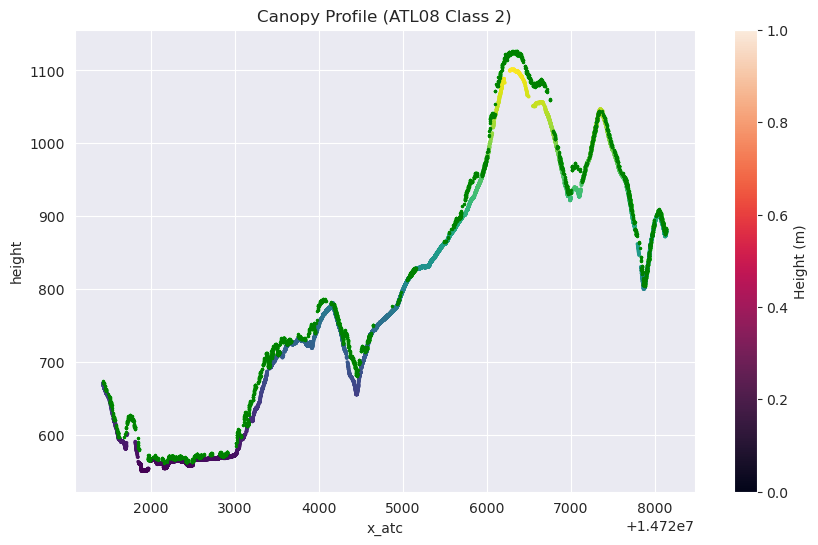

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_canopy_orto["x_atc"],
    df_canopy_orto["orthometric_height"],
    c="lime",  # якщо фіксований колір
    s=2,
    label="Canopy"
)
plt.scatter(
    df_ground_orto["x_atc"],
    df_ground_orto["orthometric_height"],
    c=df_ground_orto["orthometric_height"],  # той самий df
    cmap="viridis",
    s=3,
    label="Ground (ortho)"
)

plt.scatter(
    df_canopy_orto["x_atc"],
    df_canopy_orto["orthometric_height"],
    c="g",  # якщо фіксований колір
    s=2,
    label="Canopy"
)

plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Canopy Profile (ATL08 Class 2)")
plt.colorbar(label="Height (m)")
plt.grid(True)
plt.show()






In [41]:

dem_root = Path("data_clipped")
dem_paths = list(dem_root.rglob("*_egg2015.tif"))

In [42]:


# Основний цикл
for dem_path in dem_paths:
    name = dem_path.stem.replace("_egg2015", "")
    with rasterio.open(dem_path) as src:
        # Перевірка CRS
        if src.crs.to_epsg() not in [4326, 4979] or df_ortometric.crs.to_epsg() not in [4326, 4979]:
            raise ValueError(f"❌ CRS не сумісні: {name} vs ICESat")

        # Витяг DEM-висот
        dem_values = list(sample_gen(src, coords))
        col_dem = f"h_{name}"
        col_delta = f"delta_{name}"

        # Запис у GeoDataFrame
        df_ortometric[col_dem] = [val[0] if val else None for val in dem_values]
        df_ortometric[col_delta] = df_ortometric[col_dem] - df_ortometric["orthometric_height"]

        print(f"✅ {name}: додано {col_dem} та {col_delta}")

# Зберігаємо результат
df_ortometric.to_parquet("output/icesat2_dems_profil.parquet", index=False)
print("📦 Файл збережено до output/icesat2_dems_profil.parquet")

✅ alos_dem: додано h_alos_dem та delta_alos_dem
✅ aster_dem: додано h_aster_dem та delta_aster_dem
✅ copernicus_dеm: додано h_copernicus_dеm та delta_copernicus_dеm
✅ fab_dem: додано h_fab_dem та delta_fab_dem
✅ nasa_dem: додано h_nasa_dem та delta_nasa_dem
✅ srtm_dem: додано h_srtm_dem та delta_srtm_dem
✅ tan_dem: додано h_tan_dem та delta_tan_dem
📦 Файл збережено до output/icesat2_dems_profil.parquet


In [147]:
df_profil = gpd.read_parquet("output/icesat2_dems_profil.parquet")


In [148]:
print(df_profil.columns)

Index(['region', 'gt', 'spacecraft_velocity', 'solar_elevation', 'rgt',
       'ph_index', 'height', 'atl08_class', 'spot', 'x_atc', 'y_atc', 'cycle',
       'atl03_cnf', 'background_rate', 'quality_ph', 'geometry',
       'geoid_height', 'orthometric_height', 'dem_alos_dem', 'dem_aster_dem',
       'dem_copernicus_dеm', 'dem_fab_dem', 'dem_nasa_dem', 'dem_srtm_dem',
       'h_alos_dem', 'delta_alos_dem', 'h_aster_dem', 'delta_aster_dem',
       'h_copernicus_dеm', 'delta_copernicus_dеm', 'h_fab_dem',
       'delta_fab_dem', 'h_nasa_dem', 'delta_nasa_dem', 'h_srtm_dem',
       'delta_srtm_dem', 'h_tan_dem', 'delta_tan_dem'],
      dtype='object')


In [27]:
print(df_profil.head())

   region  gt  spacecraft_velocity  solar_elevation  rgt  ph_index  \
0       6  50          7108.268555       -32.253899  998    123494   
1       6  50          7108.268555       -32.253899  998    123497   
2       6  50          7108.268555       -32.253899  998    123498   
3       6  50          7108.268555       -32.253899  998    123499   
4       6  50          7108.268555       -32.253899  998    123500   

       height  atl08_class  spot         x_atc  ...  h_copernicus_dеm  \
0  637.587952            3     5  1.472135e+07  ...        576.345886   
1  615.246338            2     5  1.472135e+07  ...        576.345886   
2  646.714050            3     5  1.472136e+07  ...        609.472473   
3  650.420288            3     5  1.472136e+07  ...        609.472473   
4  647.244324            2     5  1.472136e+07  ...        609.472473   

   delta_copernicus_dеm   h_fab_dem  delta_fab_dem  h_nasa_dem delta_nasa_dem  \
0            -26.111065  573.288818     -29.168133  584.655

In [149]:
df_ground_profil = df_profil[
    (df_profil["rgt"] == 998) &
    (df_profil["cycle"] == 1) &
    (df_ortometric["spot"] == 1) &

    (df_profil["atl03_cnf"] == 4) &
    (df_profil["atl08_class"] == 1)
    ]

In [150]:
df_canopy_profil = df_profil[
    (df_profil["rgt"] == 998) &
    (df_profil["cycle"] == 1) &
    (df_ortometric["spot"] == 1) &

    (df_profil["atl03_cnf"] == 4) &
    (df_profil["atl08_class"] == 3)
    ]

In [151]:
df_ground_profil.columns = [col.replace("е", "e") for col in df_ground_profil.columns]
df_canopy_profil.columns = [col.replace("е", "e") for col in df_canopy_profil.columns]

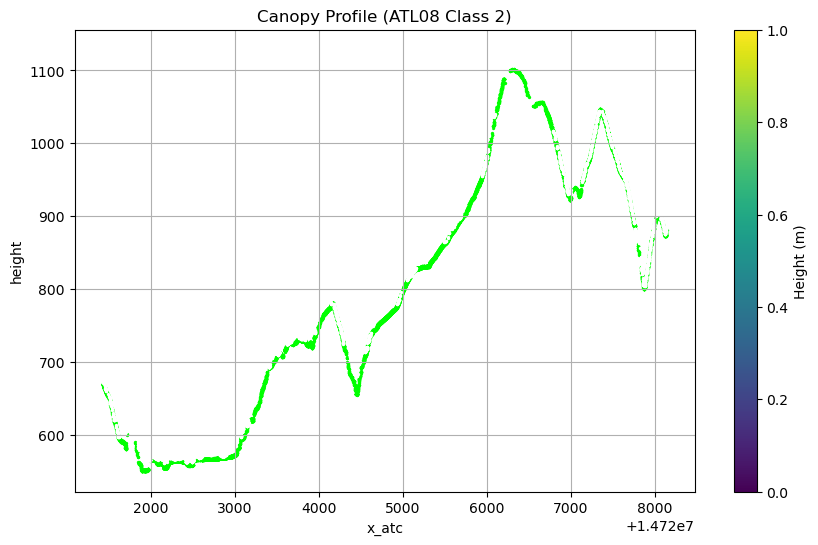

In [152]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_ground_profil["x_atc"],
    df_ground_profil["orthometric_height"],
    c="lime",  # якщо фіксований колір
    s=2,
    label="Canopy"
)

plt.scatter(
    df_canopy_profil["x_atc"],
    df_canopy_profil["orthometric_height"],
    c="w",  # якщо фіксований колір
    s=2,
    label="Canopy"
)

plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Canopy Profile (ATL08 Class 2)")
plt.colorbar(label="Height (m)")
plt.grid(True)
plt.show()



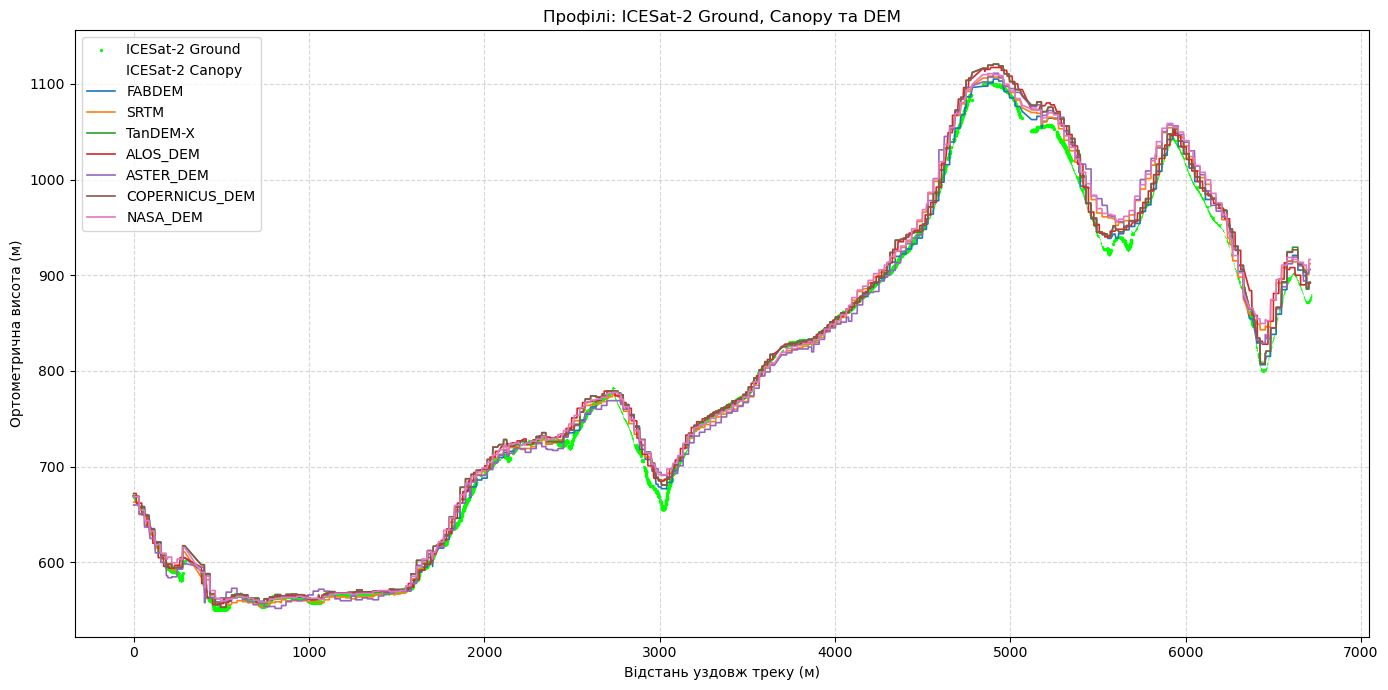

In [153]:
import matplotlib.pyplot as plt

# Копія з переведенням x_atc у метри відносно початку треку
df_ground_sorted = df_ground_profil.sort_values("x_atc").copy()
df_ground_sorted["distance_m"] = df_ground_sorted["x_atc"] - df_ground_sorted["x_atc"].min()

df_canopy_sorted = df_canopy_profil.sort_values("x_atc").copy()
df_canopy_sorted["distance_m"] = df_canopy_sorted["x_atc"] - df_ground_sorted["x_atc"].min()

# Список DEM-полів, які існують у датафреймі
dem_fields = {
    "h_fab_dem": "FABDEM",
    "h_srtm_dem": "SRTM",
    "h_tan_dem": "TanDEM-X"
}
# Опційно додаємо інші DEM, якщо вони є
extra_dems = [col for col in df_ground_sorted.columns if col.startswith("h_") and col not in dem_fields]
for col in extra_dems:
    dem_fields[col] = col.replace("h_", "").upper()

# === Побудова профілю ===
plt.figure(figsize=(14, 7))

# Ground
plt.scatter(
    df_ground_sorted["distance_m"],
    df_ground_sorted["orthometric_height"],
    s=2,
    c="lime",
    label="ICESat-2 Ground"
)

# Canopy
plt.scatter(
    df_canopy_sorted["distance_m"],
    df_canopy_sorted["orthometric_height"],
    s=2,
    c="white",
    label="ICESat-2 Canopy"
)

# DEM профілі
for col, label in dem_fields.items():
    if col in df_ground_sorted.columns:
        plt.plot(
            df_ground_sorted["distance_m"],
            df_ground_sorted[col],
            linewidth=1.2,
            label=label
        )

# Оформлення
plt.xlabel("Відстань уздовж треку (м)")
plt.ylabel("Ортометрична висота (м)")
plt.title("Профілі: ICESat-2 Ground, Canopy та DEM")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [154]:
# 1. Сортуємо профіль по x_atc
df_sorted = df_ground_profil.sort_values("x_atc").copy()

# 2. Переводимо x_atc у відстань у метрах відносно початку
df_sorted["distance_m"] = df_sorted["x_atc"] - df_sorted["x_atc"].min()


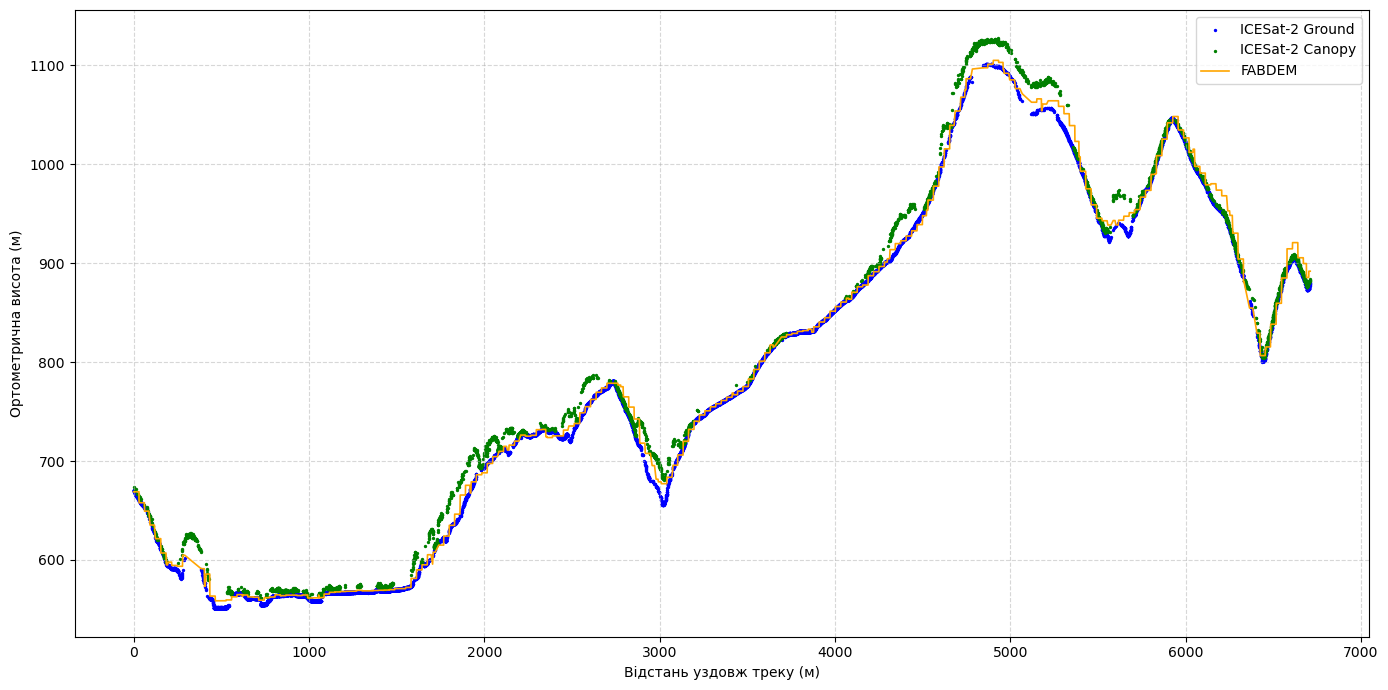

In [155]:
import matplotlib.pyplot as plt

# 1. Сортуємо профіль по x_atc
df_sorted = df_ground_profil.sort_values("x_atc").copy()

# 2. Переводимо x_atc у відстань у метрах відносно початку
df_sorted["distance_m"] = df_sorted["x_atc"] - df_sorted["x_atc"].min()

# 3. Побудова графіку
plt.figure(figsize=(14, 7))

# ICESat-2 Ground
plt.scatter(
    df_sorted["distance_m"],
    df_sorted["orthometric_height"],
    color="b",
    s=2,
    label="ICESat-2 Ground"
)

# ICESat-2 Canopy
plt.scatter(
    df_canopy_profil["x_atc"] - df_sorted["x_atc"].min(),  # теж у метри
    df_canopy_profil["orthometric_height"],
    color="g",
    s=2,
    label="ICESat-2 Canopy"
)

# 4. DEM моделі
dem_profiles = {
    "FABDEM": "h_fab_dem",
    # "SRTM": "h_srtm_dem",
    # "TanDEM-X": "h_tan_dem",
    # додай сюди інші DEM при потребі
}

colors = {
    "FABDEM": "orange",
    "SRTM": "cyan",
    "TanDEM-X": "magenta"
}

for label, col in dem_profiles.items():
    if col in df_sorted.columns:
        plt.plot(
            df_sorted["distance_m"],
            df_sorted[col],
            color=colors.get(label, "gray"),
            linewidth=1.2,
            label=label
        )

# 5. Оформлення
plt.xlabel("Відстань уздовж треку (м)")
plt.ylabel("Ортометрична висота (м)")
# plt.title("Canopy vs Ground vs DEM Profiles")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [156]:
import matplotlib.pyplot as plt
import os

# Назви DEM для підпису
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dem": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}

def plot_icesat_vs_single_dem_1(df_ground, df_canopy, dem_key, save=False, output_dir="figures"):
    dem_col = f"h_{dem_key}"
    dem_label = dem_name_map.get(dem_key, dem_key.upper())

    if dem_col not in df_ground.columns:
        print(f"❌ Колонка {dem_col} не знайдена у DataFrame.")
        return

    plt.figure(figsize=(14, 6))

    # Ground points
    plt.scatter(df_ground["distance_m"], df_ground["orthometric_height"],
                color="black", s=4, label="ICESat-2 Ground")

    # Canopy points
    plt.scatter(df_canopy["distance_m"], df_canopy["orthometric_height"],
                color="forestgreen", s=4, label="ICESat-2 Canopy")

    # DEM
    plt.plot(df_ground["distance_m"], df_ground[dem_col],
             color="orange", linewidth=2, label=dem_label)

    # Оформлення
    plt.xlabel("Відстань уздовж треку (м)", fontsize=12)
    plt.ylabel("Ортометрична висота (м н.р.м.)", fontsize=12)
    # plt.title(f"Профіль: ICESat-2 проти {dem_label}", fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()

    # Збереження
    if save:
        os.makedirs(output_dir, exist_ok=True)
        filepath = f"{output_dir}/icesat_vs_{dem_key}.png"
        plt.savefig(filepath, dpi=300)
        print(f"✅ Збережено до: {filepath}")

    plt.show()



In [157]:
# Сортуємо та додаємо координату відстані вздовж треку
df_ground_sorted = df_ground_profil.sort_values("x_atc").copy()
df_ground_sorted["distance_m"] = df_ground_sorted["x_atc"] - df_ground_sorted["x_atc"].min()

df_canopy_sorted = df_canopy_profil.sort_values("x_atc").copy()
df_canopy_sorted["distance_m"] = df_canopy_sorted["x_atc"] - df_ground_sorted["x_atc"].min()


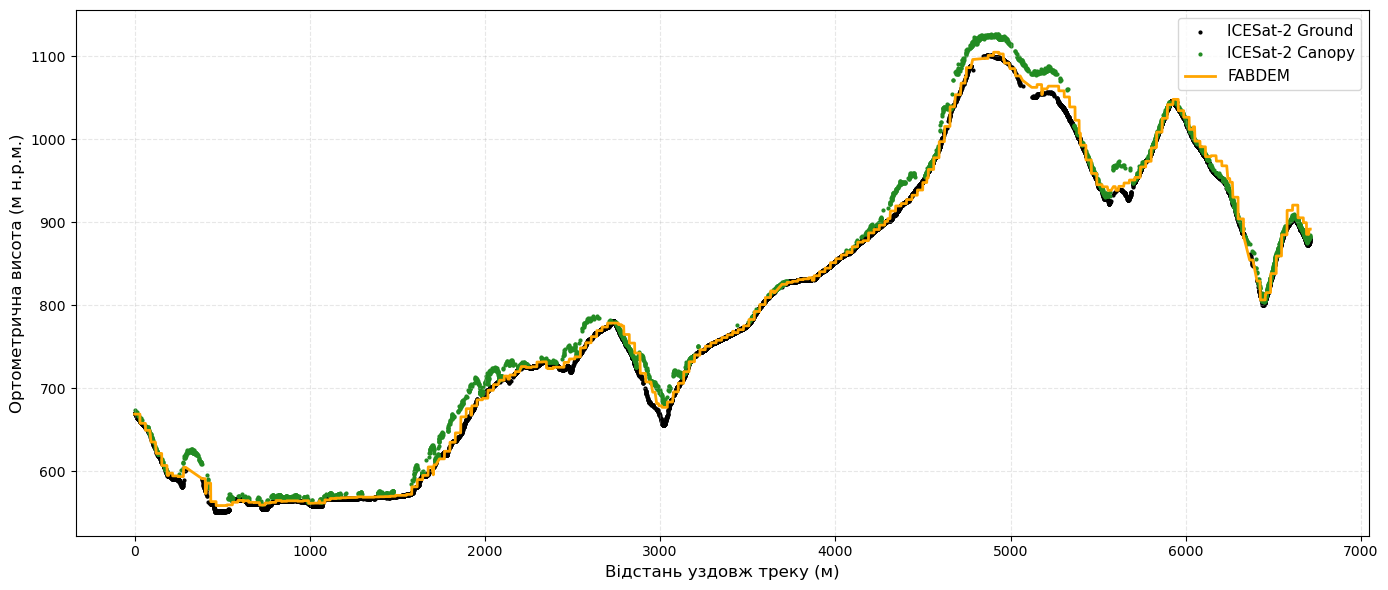

In [158]:
plot_icesat_vs_single_dem_1(df_ground_sorted, df_canopy_sorted, "fab_dem")


In [ ]:
import matplotlib.pyplot as plt
import os
plt.style.use('default')
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dem": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}

In [179]:


def plot_icesat_vs_single_dem(df_ground, df_canopy, dem_key, save=False, output_dir="figures"):
    dem_col = f"h_{dem_key}"
    dem_label = dem_name_map.get(dem_key, dem_key.upper())

    if dem_col not in df_ground.columns:
        print(f"❌ Колонка {dem_col} не знайдена у DataFrame.")
        return

    fig, ax = plt.subplots(figsize=(14, 6), facecolor='white')

    # === Дані ===
    line_ground, = ax.plot(df_ground["distance_m"], df_ground["orthometric_height"],
            linestyle='None', marker='o', markersize=0.4,
            color='gray', alpha=0.4, label="ICESat-2 Ground", zorder=3)

    line_canopy, = ax.plot(df_canopy["distance_m"], df_canopy["orthometric_height"],
            linestyle='None', marker='o', markersize=0.5,
            color='forestgreen', alpha=0.7, label="ICESat-2 Canopy", zorder=2)

    line_dem, = ax.plot(df_ground["distance_m"], df_ground[dem_col],
            color="orange", linewidth=1.6, label=dem_label, zorder=1)

    # === Оформлення ===
    ax.set_xlabel("Відстань уздовж треку (м)", fontsize=12, color="black")
    ax.set_ylabel("Ортометрична висота (м н.р.м.)", fontsize=12, color="black")
    ax.tick_params(axis='both', colors='black')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_color('black')

    ax.grid(True, linestyle="--", alpha=0.3, color="gray", zorder=0)
# Легенда
# Додавання легенди
    legend = ax.legend(
        handles=[line_ground, line_canopy, line_dem],
        fontsize=11,
        facecolor="white",
        edgecolor="black",
        loc="upper center",         # Положення по центру вгорі
        bbox_to_anchor=(0.5, -0.15),  # Винесення вниз (координата y < 0)
        ncol=3,                    # Розміщення в один ряд
        frameon=True               # Рамка
    )

    # Зміна розміру маркерів і непрозорості тільки у легенді
    for legline in legend.get_lines():
        legline.set_alpha(1.0)
        legline.set_linewidth(3)  # якщо це лінія
        legline.set_markersize(4)  # якщо це маркер
    # === Збереження ===
    if save:
        os.makedirs(output_dir, exist_ok=True)
        filepath = f"{output_dir}/icesat_vs_{dem_key}.png"
        plt.savefig(filepath, dpi=300, facecolor='white', bbox_inches='tight')
        print(f"✅ Збережено до: {filepath}")

    plt.show()



✅ Збережено до: figures/icesat_vs_fab_dem.png


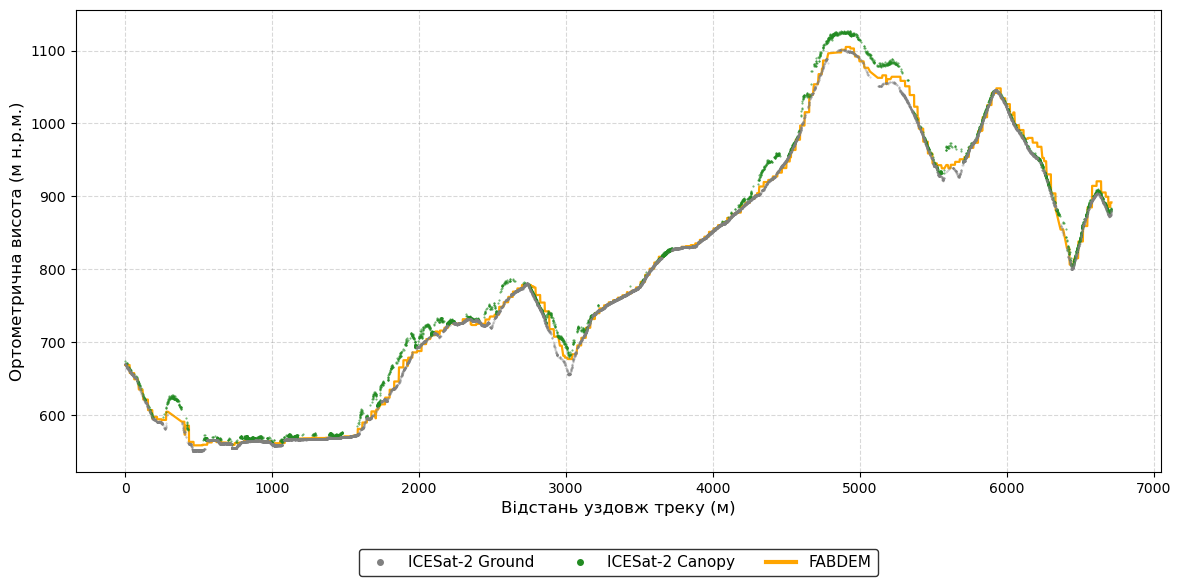

In [180]:
plot_icesat_vs_single_dem(df_ground_sorted, df_canopy_sorted, "fab_dem", save=True)


In [161]:
xmin = 410
xmax = 630

df_ground_zoom = df_ground_sorted[df_ground_sorted["distance_m"].between(xmin, xmax)]
df_canopy_zoom = df_canopy_sorted[df_canopy_sorted["distance_m"].between(xmin, xmax)]

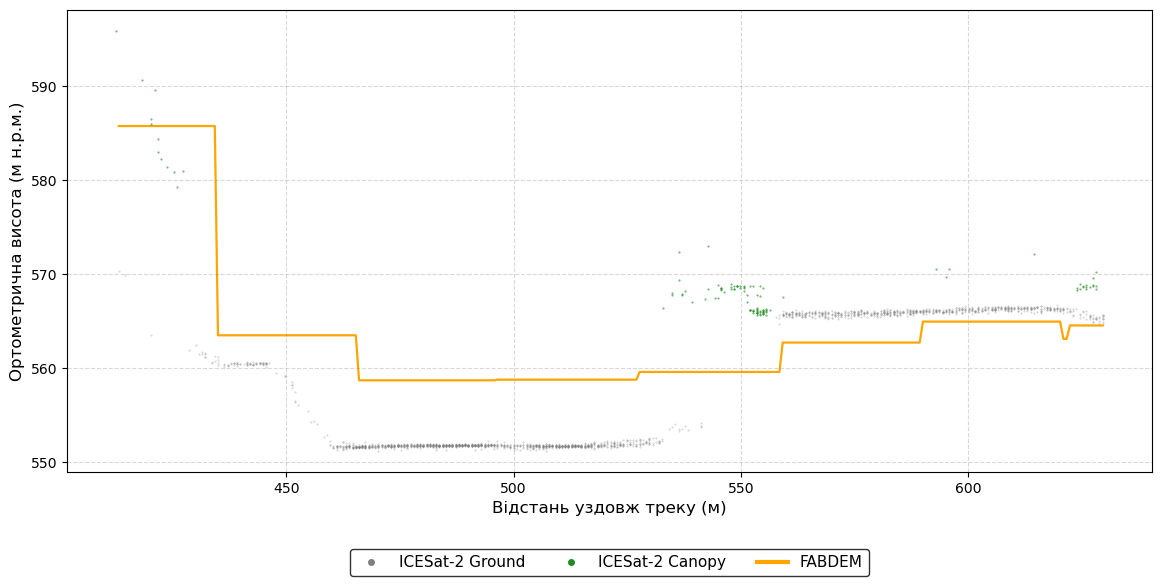

In [162]:
plot_icesat_vs_single_dem(df_ground_zoom, df_canopy_zoom, "fab_dem")


In [173]:
import matplotlib.pyplot as plt
import os

def plot_icesat_vs_single_dem_with_stats_2(df_ground, df_canopy, dem_key, save=False, output_dir="figures"):
    dem_col = f"h_{dem_key}"
    delta_col = f"delta_{dem_key}"
    dem_label = dem_name_map.get(dem_key, dem_key.upper())

    fig, ax = plt.subplots(figsize=(14, 6))

    # === Дані ===
    line_ground, = ax.plot(df_ground["distance_m"], df_ground["orthometric_height"],
        color='black', linewidth=1.5, alpha=0.7, label="ICESat-2 Ground", zorder=2)

    line_canopy, = ax.plot(
        df_canopy["distance_m"], df_canopy["orthometric_height"],
        linestyle='None', marker='o', markersize=1.0,
        color='forestgreen', alpha=0.8, label="ICESat-2 Canopy", zorder=2)

    line_dem, = ax.plot(
        df_ground["distance_m"], df_ground[dem_col],
        color="orange", linewidth=1.6, label=dem_label, zorder=1)

    # === Похибка DEM ===
    if delta_col in df_ground.columns:
        delta = df_ground[delta_col].dropna()
        delta_mean = delta.mean()
        delta_min = delta.min()
        delta_max = delta.max()

        # Вивід на графік у верхньому центрі
        textstr = (
            f"Похибка {dem_label}:\n"
            f"Середня: {delta_mean:.1f} м\n"
            f"Мінімум: {delta_min:.1f} м\n"
            f"Максимум: {delta_max:.1f} м"
        )

        ax.text(
            0.5, 0.95, textstr,
            transform=ax.transAxes,
            fontsize=10, fontweight='bold',
            ha='center', va='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.95)
        )

    # === Оформлення ===
    ax.set_xlabel("Відстань уздовж треку (м)", fontsize=12, color="black")
    ax.set_ylabel("Ортометрична висота (м н.р.м.)", fontsize=12, color="black")
    ax.tick_params(axis='both', colors='black')
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_color('black')
    ax.grid(True, linestyle="--", alpha=0.3, color="gray", zorder=0)

    # === Легенда ===
    legend = ax.legend(
        handles=[line_ground, line_canopy, line_dem],
        fontsize=11,
        facecolor="white",
        edgecolor="black",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=True
    )

    # Зміна вигляду лише у легенді
 # Зміна вигляду лише у легенді
    for handle in legend.get_lines():  # <-- виправлення
        handle.set_alpha(1.0)
        if hasattr(handle, "set_linewidth"):
            handle.set_linewidth(3)
        if hasattr(handle, "set_markersize"):
            handle.set_markersize(4)


    plt.tight_layout()

    # === Збереження ===
    if save:
        os.makedirs(output_dir, exist_ok=True)
        filepath = f"{output_dir}/icesat_vs_{dem_key}.png"
        plt.savefig(filepath, dpi=300, facecolor='white', bbox_inches='tight')
        print(f"✅ Збережено до: {filepath}")

    plt.show()


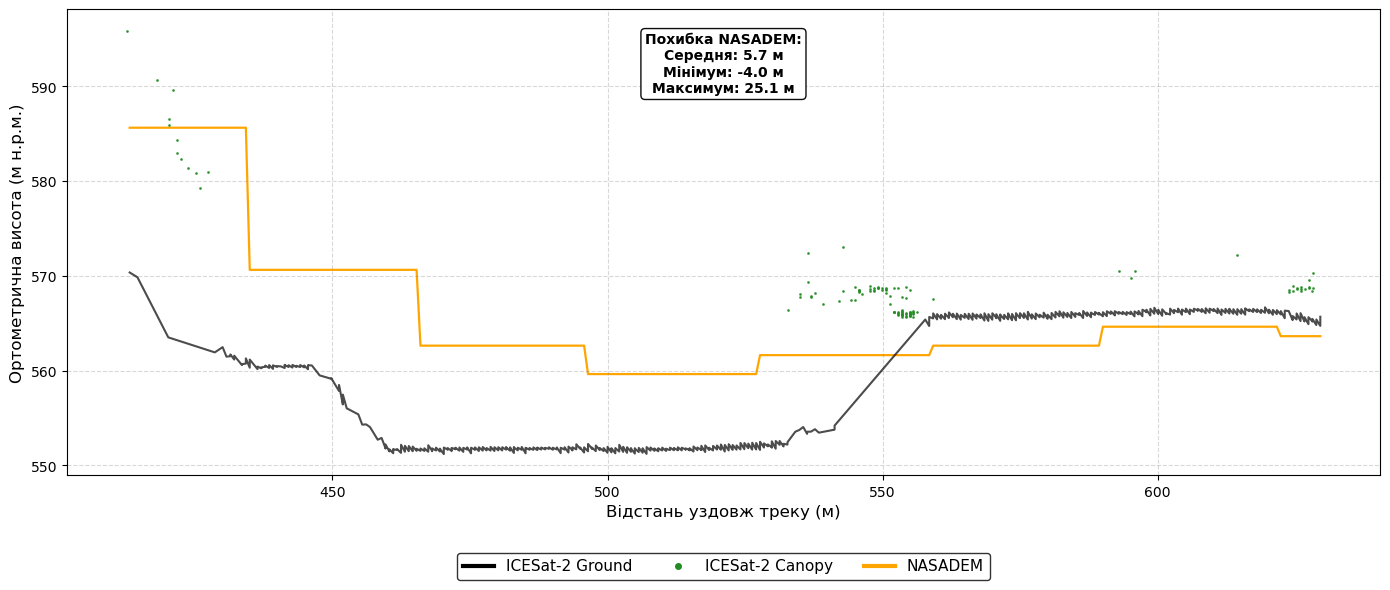

In [174]:
plot_icesat_vs_single_dem_with_stats_2(df_ground_zoom, df_canopy_zoom, "nasa_dem")


✅ Збережено до: figures/icesat_vs_tan_dem.png


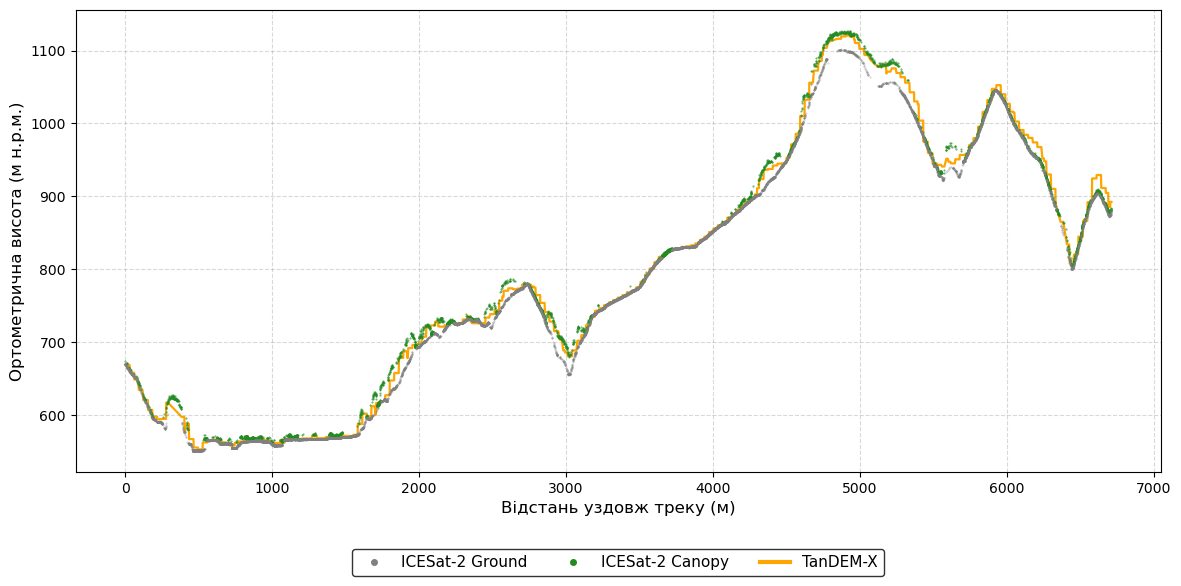

✅ Збережено до: figures/stats_zoom/icesat_vs_tan_dem.png


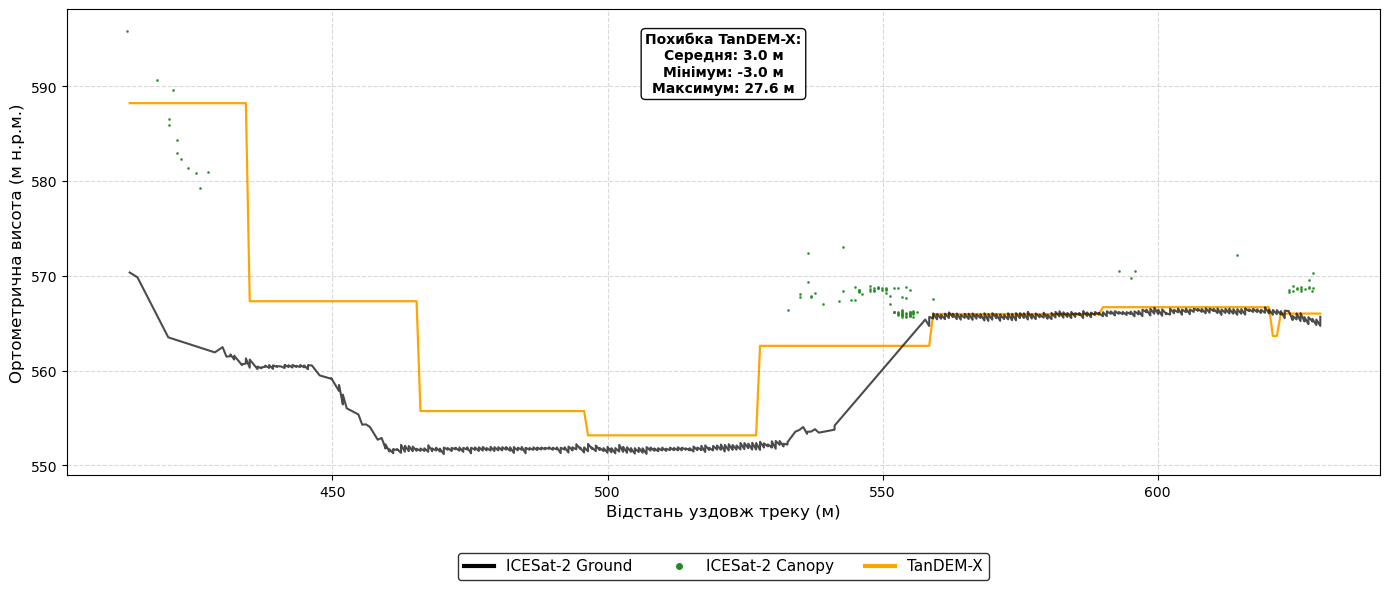

✅ Збережено до: figures/icesat_vs_srtm_dem.png


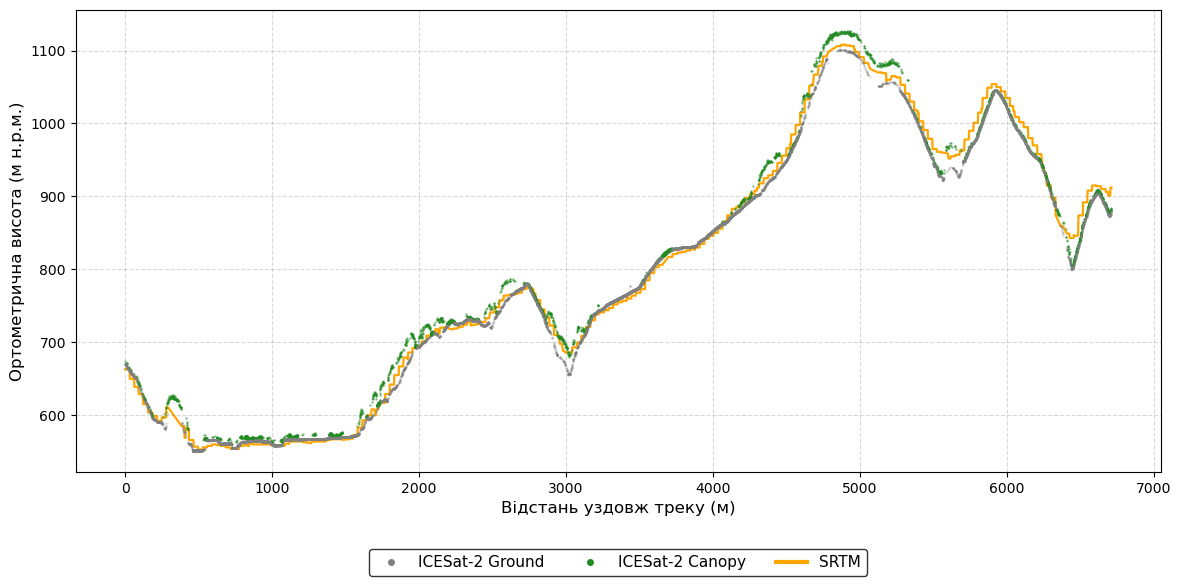

✅ Збережено до: figures/stats_zoom/icesat_vs_srtm_dem.png


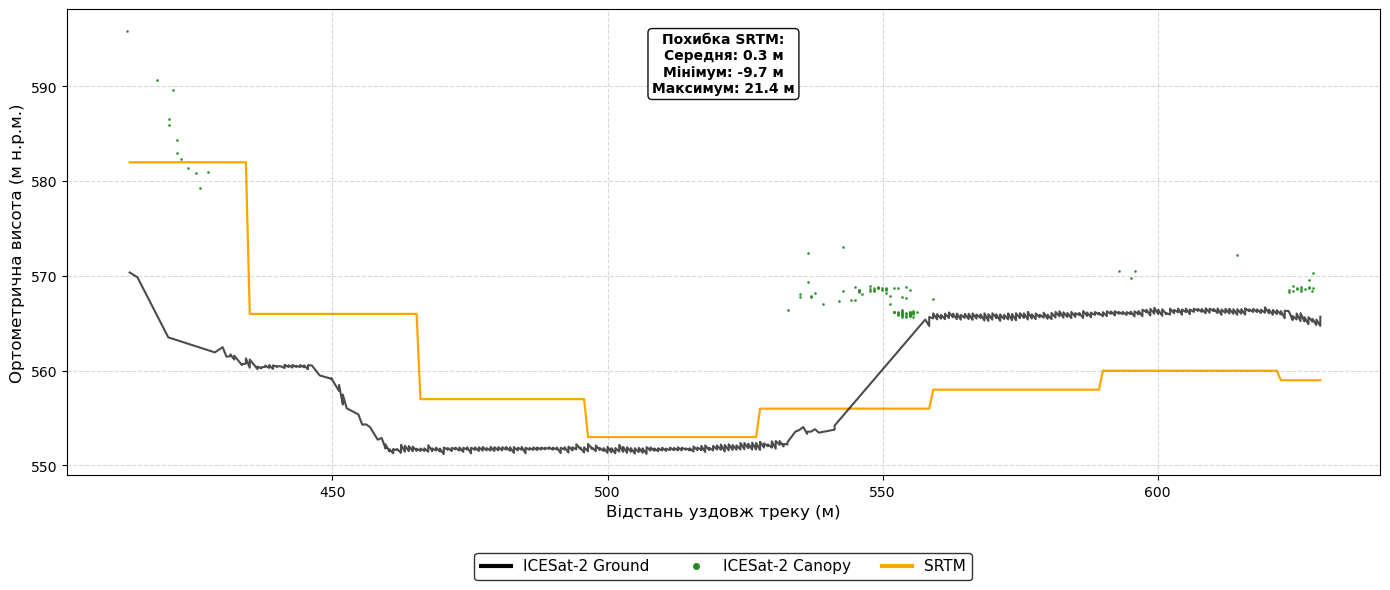

✅ Збережено до: figures/icesat_vs_fab_dem.png


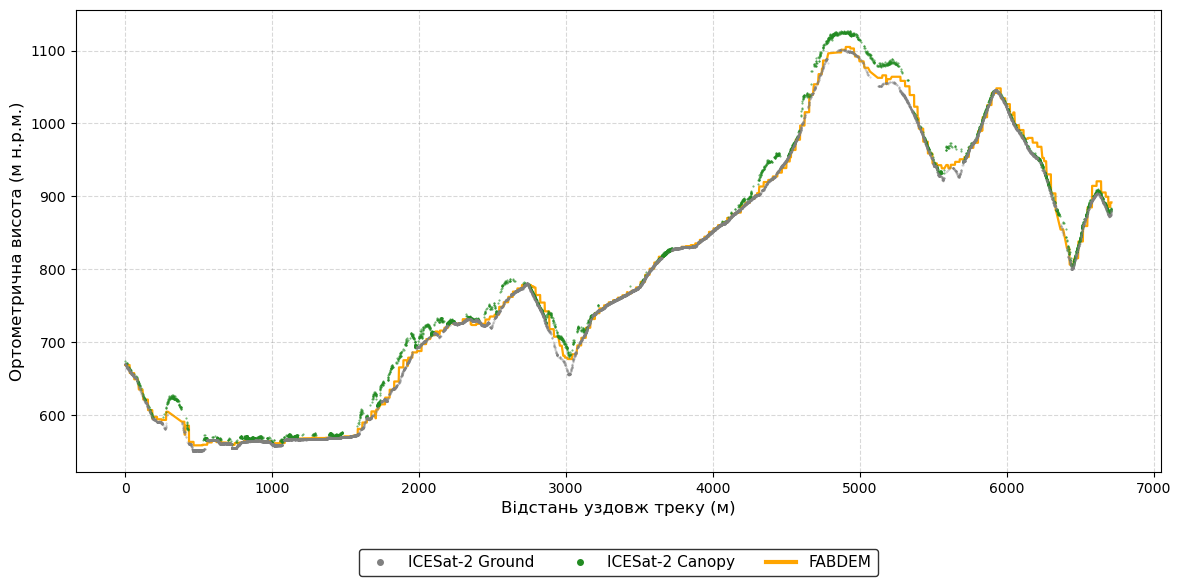

✅ Збережено до: figures/stats_zoom/icesat_vs_fab_dem.png


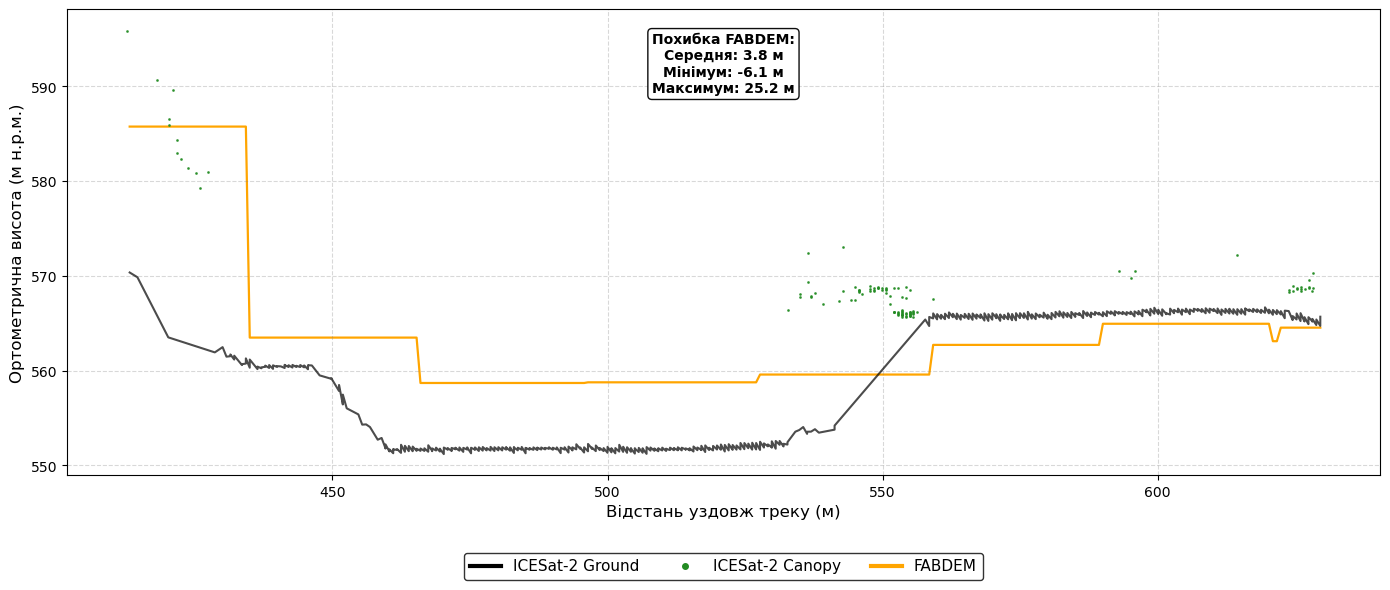

✅ Збережено до: figures/icesat_vs_copernicus_dem.png


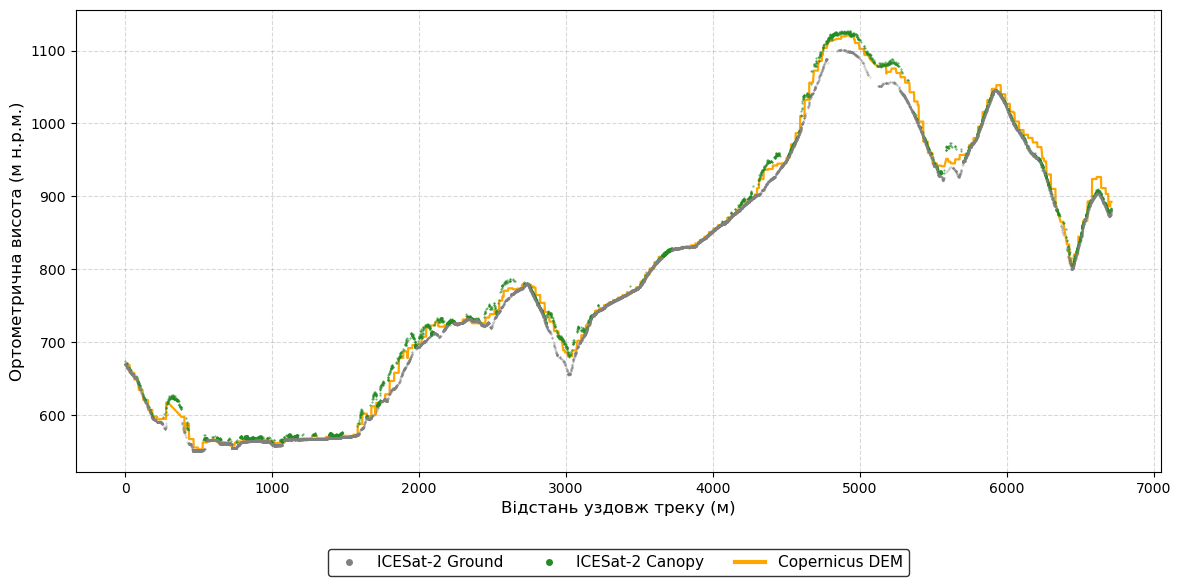

✅ Збережено до: figures/stats_zoom/icesat_vs_copernicus_dem.png


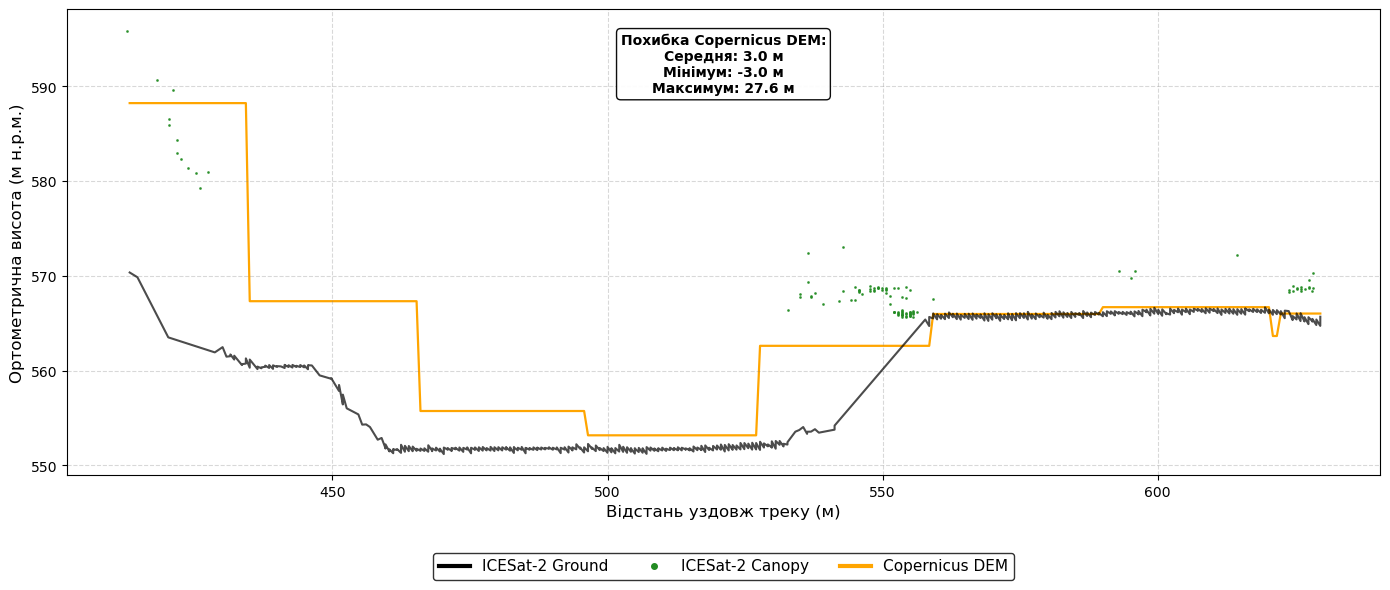

✅ Збережено до: figures/icesat_vs_nasa_dem.png


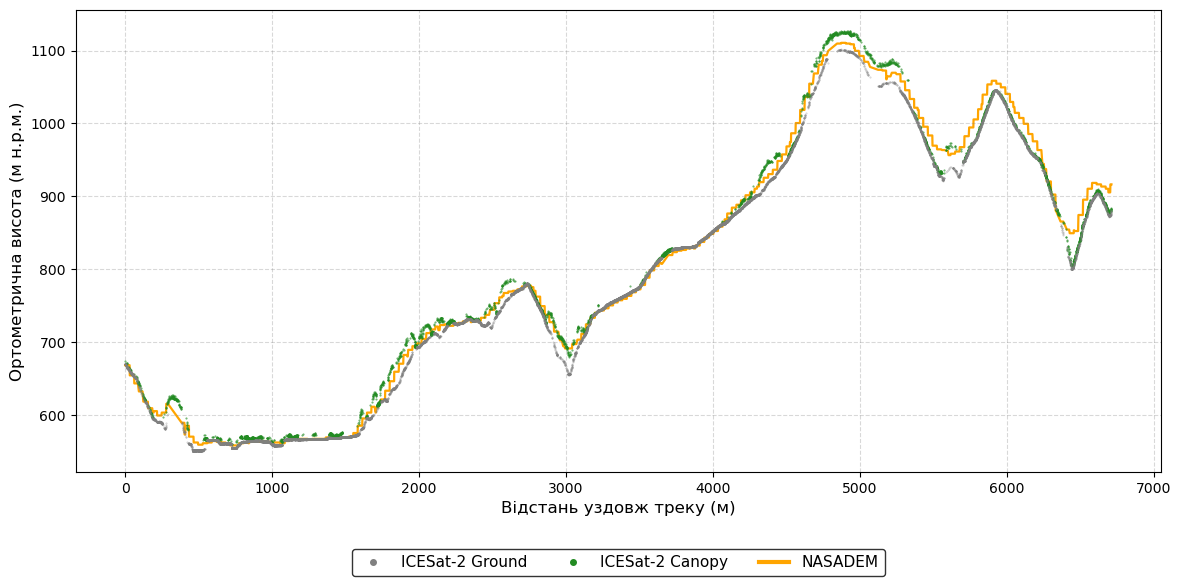

✅ Збережено до: figures/stats_zoom/icesat_vs_nasa_dem.png


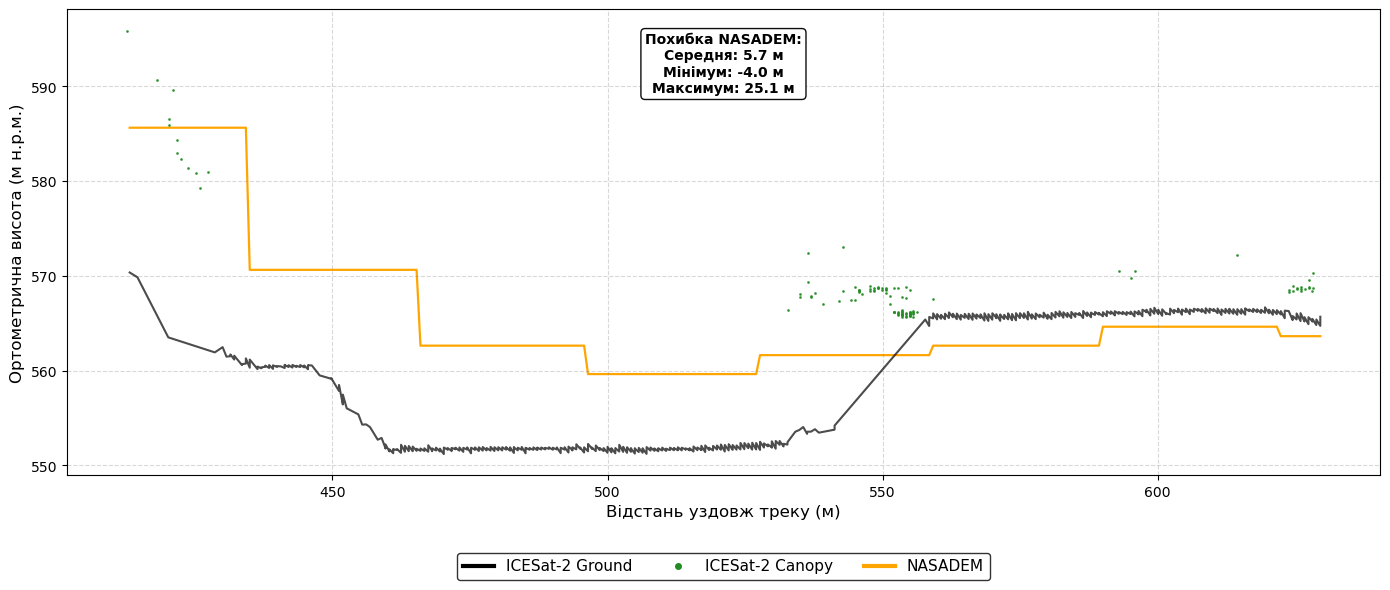

✅ Збережено до: figures/icesat_vs_alos_dem.png


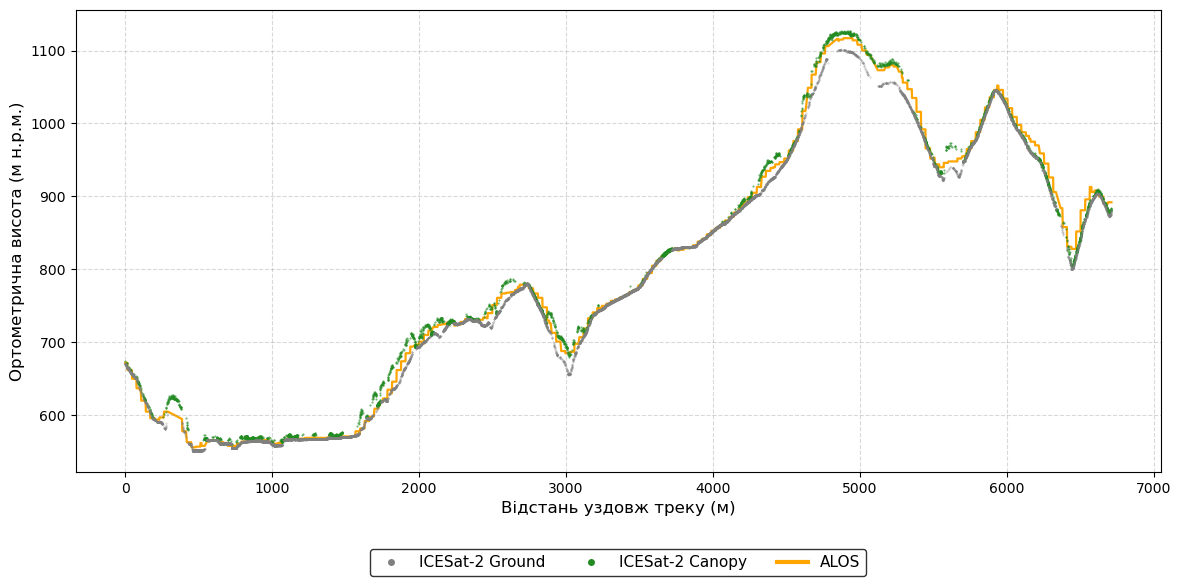

✅ Збережено до: figures/stats_zoom/icesat_vs_alos_dem.png


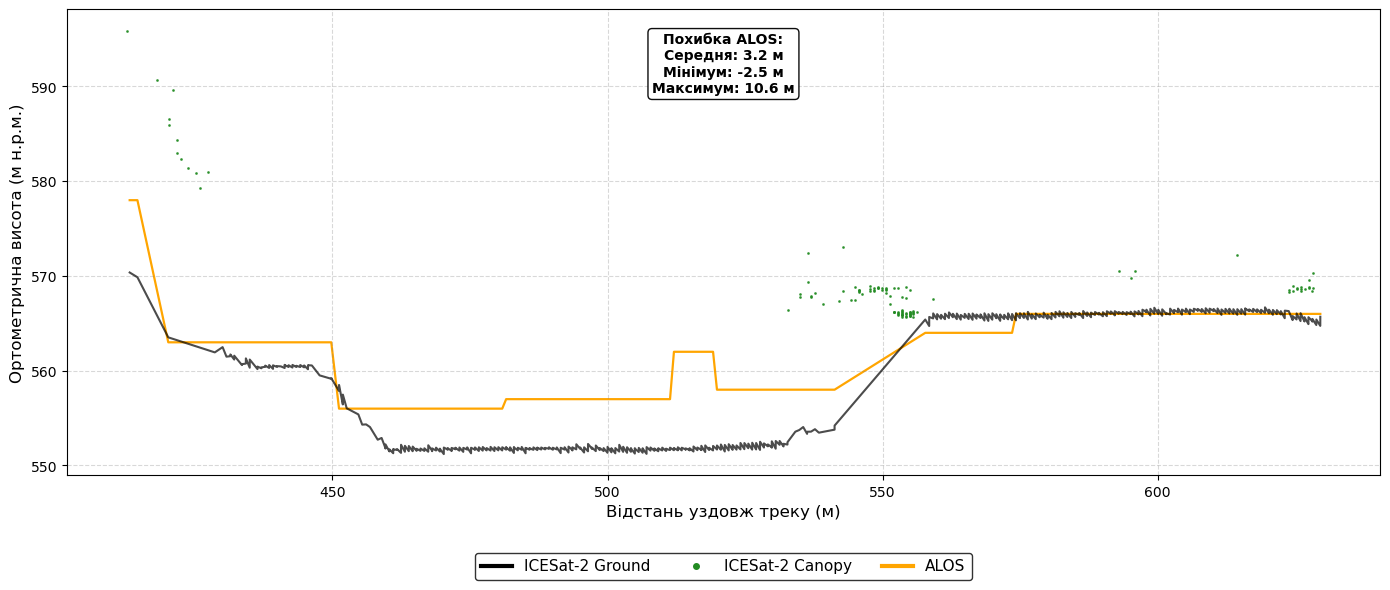

✅ Збережено до: figures/icesat_vs_aster_dem.png


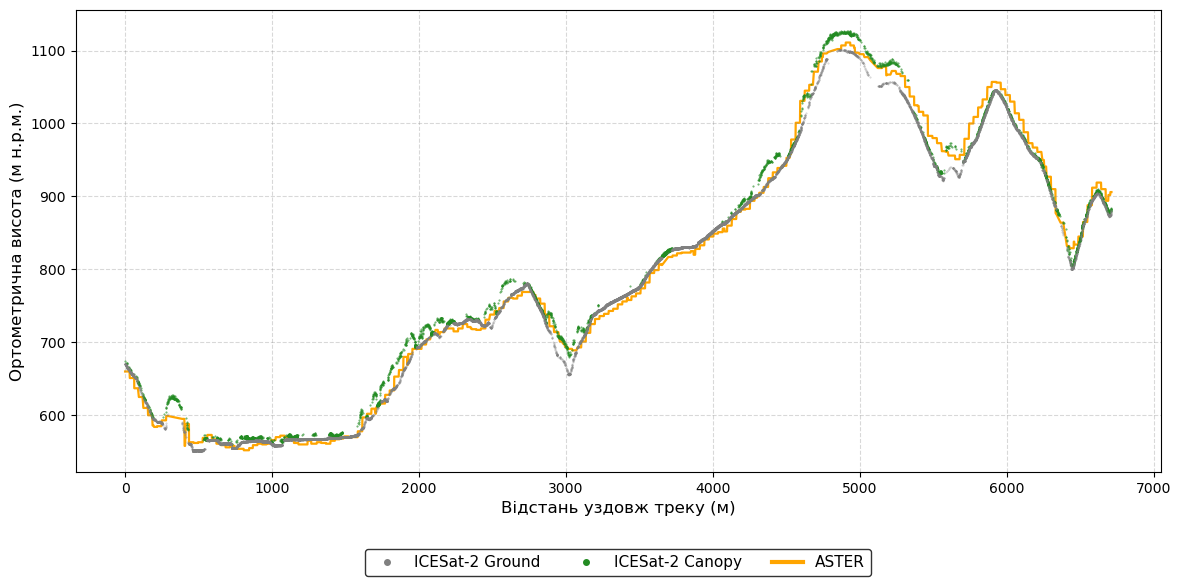

✅ Збережено до: figures/stats_zoom/icesat_vs_aster_dem.png


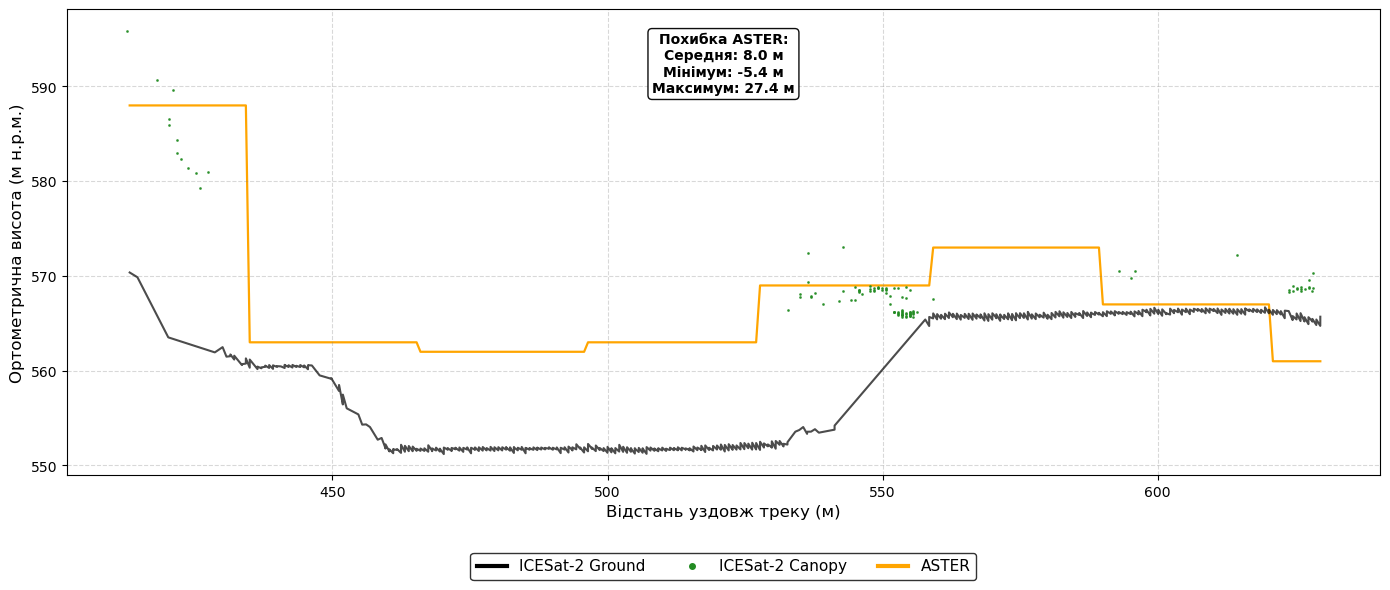

In [183]:
import os
import matplotlib.pyplot as plt

# Створимо список DEM ключів
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dem": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}

# Підготовка до створення списку ключів
dem_keys = list(dem_name_map.keys())




# Запуск циклу для кожного DEM
for dem_key in dem_keys:
    # Загальний графік
    plot_icesat_vs_single_dem(df_ground_sorted, df_canopy_sorted, dem_key, save=True)

    # Графік з похибками у межах річкової долини
    plot_icesat_vs_single_dem_with_stats_2(df_ground_zoom, df_canopy_zoom, dem_key, save=True, output_dir="figures/stats_zoom")


In [166]:
df_profil.columns

Index(['region', 'gt', 'spacecraft_velocity', 'solar_elevation', 'rgt',
       'ph_index', 'height', 'atl08_class', 'spot', 'x_atc', 'y_atc', 'cycle',
       'atl03_cnf', 'background_rate', 'quality_ph', 'geometry',
       'geoid_height', 'orthometric_height', 'dem_alos_dem', 'dem_aster_dem',
       'dem_copernicus_dеm', 'dem_fab_dem', 'dem_nasa_dem', 'dem_srtm_dem',
       'h_alos_dem', 'delta_alos_dem', 'h_aster_dem', 'delta_aster_dem',
       'h_copernicus_dеm', 'delta_copernicus_dеm', 'h_fab_dem',
       'delta_fab_dem', 'h_nasa_dem', 'delta_nasa_dem', 'h_srtm_dem',
       'delta_srtm_dem', 'h_tan_dem', 'delta_tan_dem'],
      dtype='object')